# SigLIP / SigLIP-2 정렬 평가 (KO/EN ↔ 이미지)

이 노트북은 골든 데이터셋을 대상으로 이미지–텍스트 유사도를 계산하고, 한국어(KO)와 영어(EN) 쿼리에 대해 13×13 히트맵을 시각화합니다.
- SigLIP: `google/siglip-base-patch16-256`
- SigLIP-2: `google/siglip2-base-patch16-256`

결과는 노트북 내에서 바로 확인할 수 있도록 화면에만 표시합니다(별도 저장 없음).

In [1]:
from __future__ import annotations

import json
from pathlib import Path
from typing import List, Dict

import matplotlib.pyplot as plt
import torch
from PIL import Image
from transformers import AutoModel, AutoProcessor

MODEL_SIGLIP = "google/siglip-base-patch16-256"
MODEL_SIGLIP2 = "google/siglip2-base-patch16-256"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
def find_repo_root(start: Path | None = None) -> Path:
    start = start or Path.cwd()
    for p in [start, *start.parents]:
        candidate = p / "data" / "golden_data" / "fashion_golden_queries_ko.json"
        if candidate.exists():
            return p
    return Path.cwd()

repo_root = find_repo_root()
golden_json = repo_root / "data" / "golden_data" / "fashion_golden_queries_ko.json"
image_dir = repo_root / "data" / "golden_data" / "image"
golden_json, image_dir

(WindowsPath('d:/project/ffs_v3/data/golden_data/fashion_golden_queries_ko.json'),
 WindowsPath('d:/project/ffs_v3/data/golden_data/image'))

In [3]:
def load_golden_records(json_path: Path) -> List[Dict]:
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # Ensure 1..N indexing order
    for i, d in enumerate(data, start=1):
        d['index'] = i
    return data

def load_images_by_indices(image_dir: Path, indices: List[int]) -> List[Image.Image]:
    images: List[Image.Image] = []
    for idx in indices:
        cand = list(image_dir.glob(f'{idx}.*'))
        if not cand:
            raise FileNotFoundError(f'Image not found for index={idx} in {image_dir}')
        images.append(Image.open(cand[0]).convert('RGB'))
    return images

def compute_probs(model_name: str, images: List[Image.Image], texts: List[str]) -> torch.Tensor:
    model = AutoModel.from_pretrained(model_name).to(device).eval()
    processor = AutoProcessor.from_pretrained(model_name)
    inputs = processor(text=texts, images=images, padding='max_length', truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.sigmoid(outputs.logits_per_image).detach().cpu()

def plot_heatmap(probs: torch.Tensor, title: str):
    arr = probs.numpy()
    fig, ax = plt.subplots(figsize=(7.5, 7))
    im = ax.imshow(arr, cmap='viridis', vmin=0.0, vmax=1.0, aspect='auto')
    ax.set_title(title)
    ax.set_xlabel('Queries (1..N)')
    ax.set_ylabel('Images (1..N)')
    ax.set_xticks(range(arr.shape[1]))
    ax.set_yticks(range(arr.shape[0]))
    ax.set_xticklabels([str(i) for i in range(1, arr.shape[1] + 1)])
    ax.set_yticklabels([str(i) for i in range(1, arr.shape[0] + 1)])
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Similarity (sigmoid)')
    fig.tight_layout()
    plt.show()
    plt.close(fig)

def top1_report(probs: torch.Tensor, tag: str):
    arr = probs.numpy()
    top1 = arr.argmax(axis=1)
    for i, j in enumerate(top1):
        print(f'image[{i+1}] -> {tag} query[{j+1}] score={arr[i, j]:.3f}')


In [4]:
# 골든 데이터 로드
records = load_golden_records(golden_json)
indices = [int(r.get('index', i+1)) for i, r in enumerate(records)]
texts_ko = [r['user_query_ko'] for r in records]
texts_en = [r.get('user_query_en', '').strip() for r in records]
has_en = all(bool(t) for t in texts_en)
images = load_images_by_indices(image_dir, indices)
len(records), has_en, images[0].size

(13, True, (1200, 1440))

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


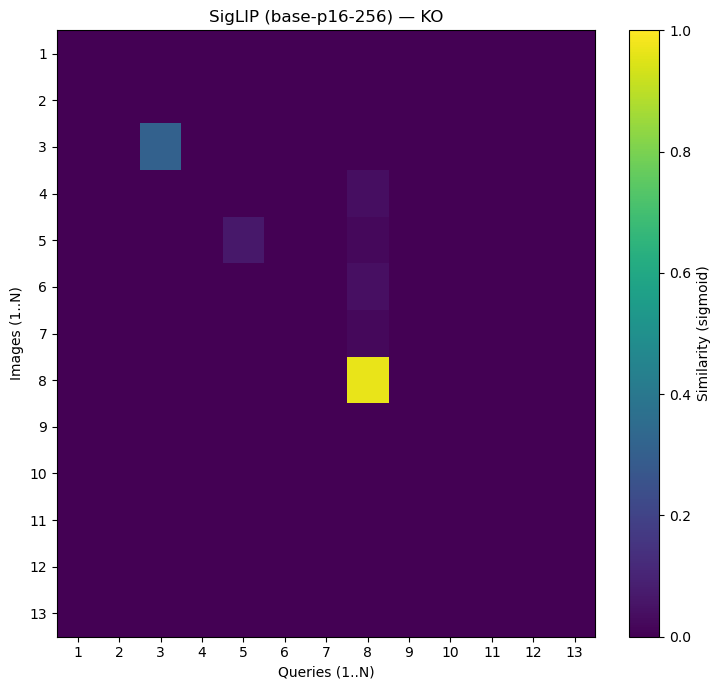

image[1] -> ko query[6] score=0.000
image[2] -> ko query[8] score=0.001
image[3] -> ko query[3] score=0.312
image[4] -> ko query[8] score=0.036
image[5] -> ko query[5] score=0.063
image[6] -> ko query[8] score=0.040
image[7] -> ko query[8] score=0.020
image[8] -> ko query[8] score=0.968
image[9] -> ko query[9] score=0.001
image[10] -> ko query[10] score=0.000
image[11] -> ko query[8] score=0.000
image[12] -> ko query[12] score=0.002
image[13] -> ko query[8] score=0.000


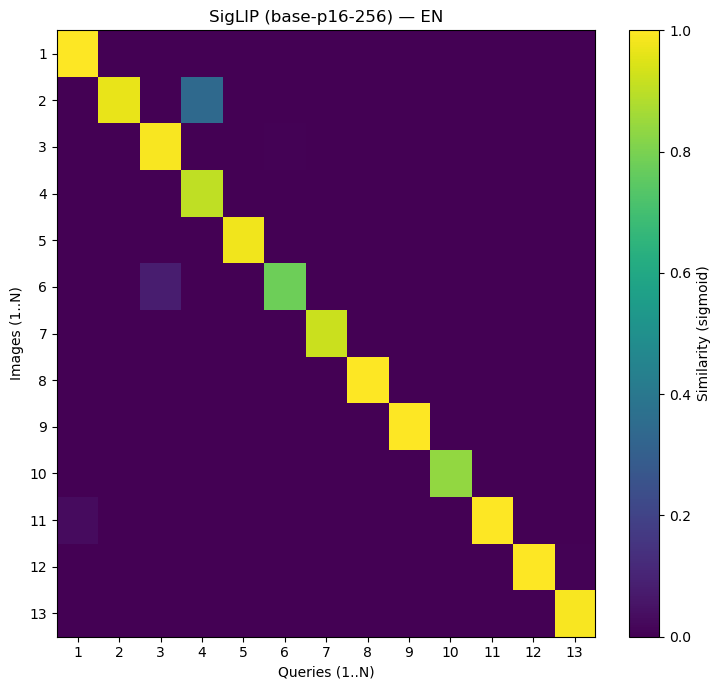

image[1] -> en query[1] score=1.000
image[2] -> en query[2] score=0.965
image[3] -> en query[3] score=0.989
image[4] -> en query[4] score=0.905
image[5] -> en query[5] score=0.979
image[6] -> en query[6] score=0.778
image[7] -> en query[7] score=0.921
image[8] -> en query[8] score=1.000
image[9] -> en query[9] score=0.999
image[10] -> en query[10] score=0.838
image[11] -> en query[11] score=0.998
image[12] -> en query[12] score=1.000
image[13] -> en query[13] score=0.991


In [5]:
# SigLIP: google/siglip-base-patch16-256
probs_siglip_ko = compute_probs(MODEL_SIGLIP, images, texts_ko)
plot_heatmap(probs_siglip_ko, 'SigLIP (base-p16-256) — KO')
top1_report(probs_siglip_ko, 'ko')

if has_en:
    probs_siglip_en = compute_probs(MODEL_SIGLIP, images, texts_en)
    plot_heatmap(probs_siglip_en, 'SigLIP (base-p16-256) — EN')
    top1_report(probs_siglip_en, 'en')
else:
    print('[WARN] No user_query_en in JSON; skipping EN for SigLIP.')


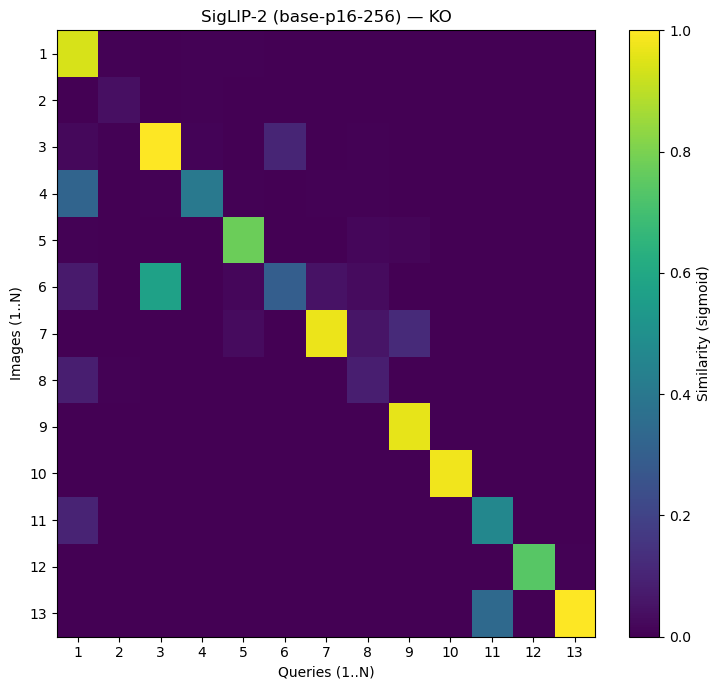

image[1] -> ko query[1] score=0.941
image[2] -> ko query[2] score=0.041
image[3] -> ko query[3] score=0.999
image[4] -> ko query[4] score=0.405
image[5] -> ko query[5] score=0.776
image[6] -> ko query[3] score=0.572
image[7] -> ko query[7] score=0.972
image[8] -> ko query[8] score=0.085
image[9] -> ko query[9] score=0.961
image[10] -> ko query[10] score=0.977
image[11] -> ko query[11] score=0.463
image[12] -> ko query[12] score=0.740
image[13] -> ko query[13] score=0.996


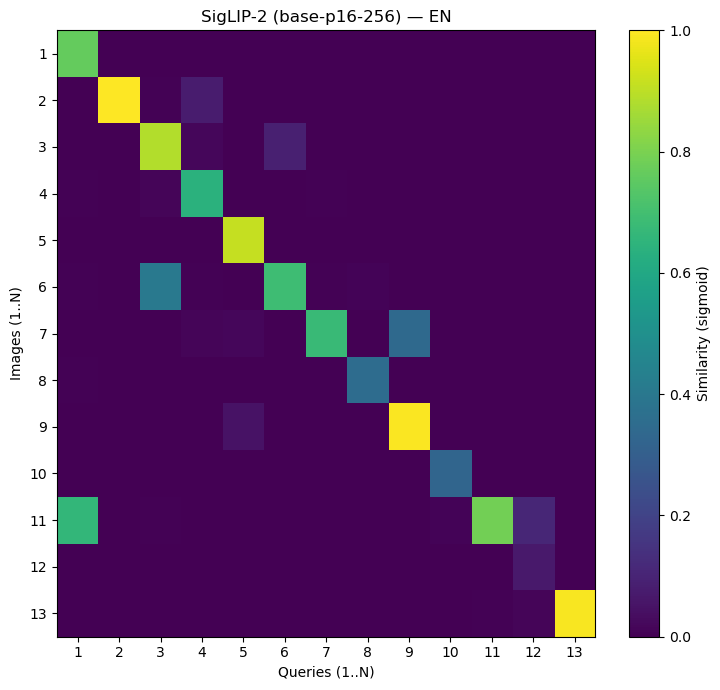

image[1] -> en query[1] score=0.765
image[2] -> en query[2] score=0.997
image[3] -> en query[3] score=0.884
image[4] -> en query[4] score=0.638
image[5] -> en query[5] score=0.913
image[6] -> en query[6] score=0.689
image[7] -> en query[7] score=0.677
image[8] -> en query[8] score=0.354
image[9] -> en query[9] score=0.994
image[10] -> en query[10] score=0.324
image[11] -> en query[11] score=0.787
image[12] -> en query[12] score=0.068
image[13] -> en query[13] score=0.991


In [6]:
# SigLIP-2: google/siglip2-base-patch16-256
probs_siglip2_ko = compute_probs(MODEL_SIGLIP2, images, texts_ko)
plot_heatmap(probs_siglip2_ko, 'SigLIP-2 (base-p16-256) — KO')
top1_report(probs_siglip2_ko, 'ko')

if has_en:
    probs_siglip2_en = compute_probs(MODEL_SIGLIP2, images, texts_en)
    plot_heatmap(probs_siglip2_en, 'SigLIP-2 (base-p16-256) — EN')
    top1_report(probs_siglip2_en, 'en')
else:
    print('[WARN] No user_query_en in JSON; skipping EN for SigLIP-2.')
